# Likelihood Fields for Range Finders

In [1]:
# map info: sensor (0, 0) point1 (-1, 2) point2 (0.5, 3) rectangle (-5, 6) width 3 height 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from scipy import spatial
from scipy.stats import norm
%matplotlib inline

## Original Map

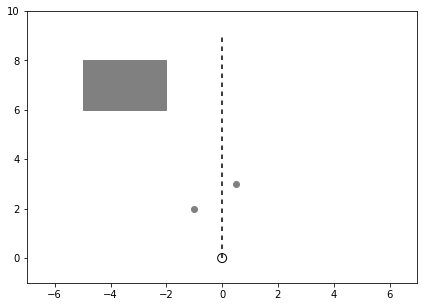

In [2]:
plt.figure(figsize=(7, 5))
ax = plt.gca()
ax.set_xlim([-7, 7])
ax.set_ylim([-1,10])
ax.scatter(-1, 2, color='grey')
ax.scatter(0.5, 3, color='grey')
ax.scatter(0, 0, s=80, facecolors='none', edgecolors='black')
ax.add_patch(patches.Rectangle((-5, 6), 3, 2,color='grey'))
ax.plot((0,0),(0,9), dashes=(3,3), color='black')
plt.show()

In [3]:
x = np.linspace(-7, 7, 1000)
y = np.linspace(-1, 10, 1000)
X, Y = np.meshgrid(x, y)

In [4]:
# reference https://stackoverflow.com/questions/16343752/numpy-where-function-multiple-conditions
def get_map_obstacles(X, Y):
    square = ((X>=-5) & (X<=-2) & (Y>=6) & (Y<=8)) 
    point1 = ((X<-0.99)&(X>-1.01) & (Y<2.01)&(Y>1.99))
    point2 = ((X<0.51)&(X>0.49) & (Y<3.01)&(Y>2.99))
    return square | point1 | point2

# Shoe-horn existing data for entry into KDTree routines
# https://stackoverflow.com/questions/41841354/keeping-track-of-indices-change-in-numpy-reshape?rq=1
# https://stackoverflow.com/questions/10818546/finding-index-of-nearest-point-in-numpy-arrays-of-x-and-y-coordinates
def do_kdtree(combined_x_y_arrays,points):
    mytree = spatial.cKDTree(combined_x_y_arrays)
    dist, indexes = mytree.query(points)
    return indexes

def get_likelihood_field(X, Y, X_test, Y_test, stdv):
    '''
    X, Y is meshgrid coordinates
    '''
    obstacles_boolean = get_map_obstacles(X, Y)
    X_ob, Y_ob = X[obstacles_boolean], Y[obstacles_boolean]
    combined_x_y_arrays = np.dstack([X_ob.ravel(),Y_ob.ravel()])[0]
    points_list = np.stack((X_test.ravel(),Y_test.ravel()), axis=1)
    nearest_point_idxs = do_kdtree(combined_x_y_arrays,points_list)
    dist_vec = np.sqrt((X_test.ravel()-X_ob[nearest_point_idxs])**2 + (Y_test.ravel()-Y_ob[nearest_point_idxs])**2)
    norm_func = norm(scale=stdv)
    result_prob = norm_func.pdf(dist_vec)
    result_prob = result_prob.reshape(X_test.shape)
    return result_prob

## Map with Likelihood

In [5]:
Z = get_likelihood_field(X, Y, X, Y, 0.8)

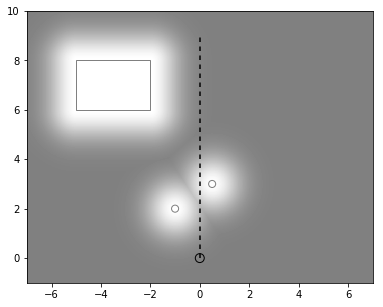

In [6]:
plt.figure(figsize=(7, 5))
ax = plt.gca()
ax.set_xlim([-7, 7])
ax.set_ylim([-1,10])
ax.scatter(-1, 2, s=50, facecolors='none', edgecolors='grey')
ax.scatter(0.5, 3, s=50, facecolors='none', edgecolors='grey')
ax.scatter(0, 0, s=80, facecolors='none', edgecolors='black')
ax.add_patch(patches.Rectangle((-5, 6), 3, 2,color='grey', fill=False))
ax.plot((0,0),(0,9), dashes=(3,3), color='black')
# https://matplotlib.org/examples/color/colormaps_reference.html
im = plt.imshow(Z, cmap=plt.get_cmap('gist_gray'), 
                origin='lower', extent=[-7, 7, -1, 10],
                vmax=abs(Z).max(), vmin=-abs(Z).max())
plt.show()

## Beam measurement probability

In [7]:
X_dashes = np.zeros(500)
left, right = 0, 10
Y_dashes = np.linspace(0,10,500)
Z_dashes = get_likelihood_field(X, Y, X_dashes, Y_dashes, 0.8)

In [8]:
# add other two items z_max = 10
params = (0.8, 0.8, 0.2)
z_max = 10
Z_dashes = Z_dashes*params[0] + np.ones(Z_dashes.shape)/(right-left)*params[1]
z_max_idxs = np.where(np.abs(Y_dashes-10)<0.1)
Z_dashes[z_max_idxs] = Z_dashes[z_max_idxs] + np.ones(z_max_idxs[0].shape[0])*params[2]

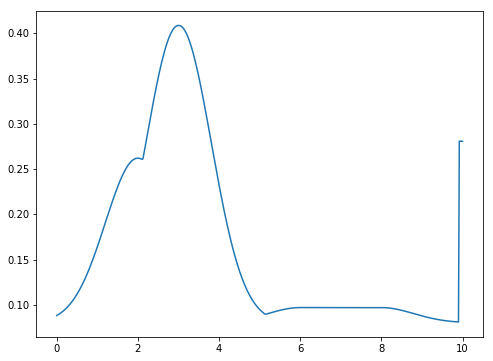

In [9]:
plt.figure(figsize=(8,6))
plt.plot(Y_dashes,Z_dashes)
plt.show()

## Example Code

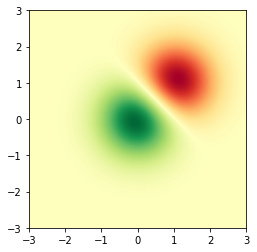

In [10]:
# reference https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html
# reference https://matplotlib.org/gallery/images_contours_and_fields/image_demo.html#sphx-glr-gallery-images-contours-and-fields-image-demo-py

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

delta = 0.025
x = y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

im = plt.imshow(Z, interpolation='bilinear', cmap=cm.RdYlGn,
                origin='lower', extent=[-3, 3, -3, 3],
                vmax=abs(Z).max(), vmin=-abs(Z).max())

plt.show()